## 0.  Imports

In [ ]:
#%cd /content/
#!rm -rf fever-scorer

In [ ]:
!git clone -b release-v2.0 https://github.com/sheffieldnlp/fever-scorer.git

fatal: destination path 'fever-scorer' already exists and is not an empty directory.


In [ ]:
%cd fever-scorer

/content/drive/MyDrive/SUNY_Poly_DSA598/datasets/FEVER/fever-scorer


In [ ]:
!pip install -r requirements.txt


In [ ]:
# Open /setup.py and add 'license="MIT"' on line 12, then overwrite the file
import os
with open('setup.py', 'r') as f:
    lines = f.readlines()
    lines[11] = 'license="MIT"\n'
with open('setup.py', 'w') as f:
    f.writelines(lines)
    f.close()
    print("setup.py updated")


setup.py updated


In [ ]:
!pip install .

Processing /content/drive/MyDrive/SUNY_Poly_DSA598/datasets/FEVER/fever-scorer
  Preparing metadata (setup.py) ... done
  Created wheel for fever-scorer: filename=fever_scorer-0.0.0-py3-none-any.whl size=8288 sha256=09b3a5adba88aff36988ffdec465a73744cfad4993dd9ef07aa5fa96369933f5
  Stored in directory: /root/.cache/pip/wheels/b0/74/66/5effd7c246496d023a24a126de91720a2cc3b6a994a6ac582c
Successfully built fever-scorer
  Attempting uninstall: fever-scorer
    Found existing installation: fever-scorer 0.0.0
    Uninstalling fever-scorer-0.0.0:
      Successfully uninstalled fever-scorer-0.0.0


In [ ]:
!pip install rouge-score

In [ ]:
import pandas as pd
import nltk  # Make sure NLTK is installed and data downloaded (e.g., nltk.download('punkt'))
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from rouge_score import rouge_scorer
import openai  # For LLM interaction
from openai import OpenAI
import numpy as np
from nltk import Tree, pos_tag, word_tokenize, ne_chunk
from nltk.corpus import stopwords
import numpy as np
from fever.scorer import fever_score # Import the FEVER scorer
from nltk import RegexpParser
import json

# Download the necessary NLTK data files
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('maxent_ne_chunker')
nltk.download('maxent_ne_chunker_tab')
nltk.download('words')
nltk.download('stopwords')
nltk.download('treebank')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package maxent_ne_chunker_tab to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package maxent_ne_chunker_tab is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package treebank to /root/nltk_data...
[nltk_data]   Package treebank is already up-to-date!
[nltk_data] Downloading package punk

True

## 1. Add data sources
<a id="1"></a>


In [ ]:
# Mount google drive
from google.colab import drive
import gc

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab import userdata
api_key = userdata.get('openaikey')
client = OpenAI(api_key=api_key)

In [ ]:
%cd ../drive/My Drive/SUNY_Poly_DSA598/

/content/drive/My Drive/SUNY_Poly_DSA598


In [ ]:
!ls -a

archive			  .git				  presentation
datasets		  .gitignore			  scratch.txt
FEVER_set_creation.ipynb  liar_gpt4omini_base_eval.ipynb  transcribe_voice_notes.ipynb
FEVER_set_update.ipynb	  Module_2_dev.ipynb		  work_documents


In [ ]:
%cd ./datasets/FEVER/

/content/drive/My Drive/SUNY_Poly_DSA598/datasets/FEVER


In [ ]:
!ls -a

AVeriTeC		  feverous_train_challenges.jsonl  GPT_sets	     tabular_sets
.DS_Store		  fever-scorer			   paper_dev.jsonl   wiki-pages
fever2-adversarial.jsonl  fever-train.jsonl		   paper_test.jsonl


In [ ]:
def load_jsonl(file_path, encoding='utf-8'):
    """Loads a JSON Lines file into a list of Python objects."""
    data = []
    with open(file_path, 'r', encoding=encoding) as f:  # Specify encoding for safety
        for line in f:
            data.append(json.loads(line))  # Parse each line individually
    return data

In [ ]:
# Data paths (replace with your actual paths if different)
fever_path = "./datasets/FEVER/"
train_clf_path = f"tabular_sets/tabular_clf_paper_dev_train/v1_segmented_sentIDs_n3461_04-04_002.csv"
valid_clf_path = f"tabular_sets/tabular_clf_paper_dev_valid/v1_segmented_sentIDs_n1482_04-04_002.csv"
train_sentEx_path = f"tabular_sets/tabular_sentEx_paper_dev_train/v1_segmented_sentIDs_n3461_04-04_002.csv"
valid_sentEx_path = f"tabular_sets/tabular_sentEx_paper_dev_valid/v1_segmented_sentIDs_n1482_04-04_002.csv"
test_path = f"paper_test.jsonl"
train_path = f"paper_dev.jsonl"

# Load datasets
train_clf = pd.read_csv(train_clf_path)
valid_clf = pd.read_csv(valid_clf_path)
train_sentEx = pd.read_csv(train_sentEx_path)
valid_sentEx = pd.read_csv(valid_sentEx_path)
test_jsonl = load_jsonl(test_path)
train_jsonl = load_jsonl(train_path)

In [ ]:
# Show the distribution of labels
print(f"Train set label distribution:")
print(train_sentEx['label'].value_counts())
print(f"Valid set label distribution:")
print(valid_sentEx['label'].value_counts())

# Balance the labels by reducing each to the minimum count
min_count = min(train_sentEx['label'].value_counts())
train_sentEx = train_sentEx.groupby('label').apply(lambda x: x.sample(min_count)).reset_index(drop=True)
min_count = min(valid_sentEx['label'].value_counts())
valid_sentEx = valid_sentEx.groupby('label').apply(lambda x: x.sample(min_count)).reset_index(drop=True)

print(f"Train set label distribution after balancing:")
print(train_sentEx['label'].value_counts())
print(f"Valid set label distribution after balancing:")
print(valid_sentEx['label'].value_counts())

Train set label distribution:
label
SUPPORTS           1156
REFUTES            1156
NOT ENOUGH INFO    1149
Name: count, dtype: int64
Valid set label distribution:
label
SUPPORTS           495
REFUTES            495
NOT ENOUGH INFO    488
Name: count, dtype: int64
Train set label distribution after balancing:
label
NOT ENOUGH INFO    1149
REFUTES            1149
SUPPORTS           1149
Name: count, dtype: int64
Valid set label distribution after balancing:
label
NOT ENOUGH INFO    488
REFUTES            488
SUPPORTS           488
Name: count, dtype: int64


<ipython-input-128-03091368d446>:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_sentEx = train_sentEx.groupby('label').apply(lambda x: x.sample(min_count)).reset_index(drop=True)
<ipython-input-128-03091368d446>:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  valid_sentEx = valid_sentEx.groupby('label').apply(lambda x: x.sample(min_count)).reset_index(drop=True)


## 2.  Test FEVER Scorer
<a id="2"></a>

In [ ]:


# Sample instances
instances = [
    {
        "label": "REFUTES",
        "predicted_label": "REFUTES",
        "predicted_evidence": [["Page1", 1], ["Page3", 2]],
        "evidence": [
            [
                [None, None, "Page1", 1],
                [None, None, "Page3", 1],
                [None, None, "Page3", 2],
            ],
        ],
    },
    {
        "label": "SUPPORTS",
        "predicted_label": "SUPPORTS",
        "predicted_evidence": [["Page3", 3]],
        "evidence": [
            [
                [None, None, "Page3", 3]
            ]
        ],
    },
    {
        "label": "NOT ENOUGH INFO",
        "predicted_label": "NOT ENOUGH INFO",
        "predicted_evidence": [],
        "evidence": [],
    },
]

# Calculate scores
strict_score, label_accuracy, precision, recall, f1 = fever_score(instances)

# Display results
print(f"Strict Score: {strict_score:.2f}")
print(f"Label Accuracy: {label_accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")


Strict Score: 0.67
Label Accuracy: 1.00
Precision: 1.00
Recall: 0.50
F1 Score: 0.67


## 3. Module 2
<a id="3"></a>

In [ ]:
def module_2_2_controls(claim, documents, entities, keywords, co_thresh=0.2, ro_thresh=0.2, verbose=0, debug=False):
    """
    Module 2: Semi-supervised Distillation for sentence extraction.

    Args:
        claim (str): The input claim.
        documents (list of str): List of retrieved documents (full text).
        entity (str):  The main entity in the claim (or None if not found).
        keywords (list of str):  Top keywords from the claim.

    Returns:
        tuple: (list of str, str):  A list of extracted evidence sentences and the exit status ("NOT ENOUGH INFO" or "OK").
    """

    # Module 2 report: a dataframe to to store inputs and outputs
    extracted_sentences = []
    max_iterations = min(5, len(documents)) # This will be determined later with actual number of sentences across all docs
    if debug:
      print(f"DEBUG 2.1.1:")
      print(f"\tNumber of documents: {len(documents)}")
      print(f"\tMax iterations: {max_iterations}")
      print("-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-")

    """
    if entities == []:
      if verbose == 1:
        print("No entities found, early exiting...")
        return [], "NOT ENOUGH INFO" # Early exit if no entity
    """

    # convert entities to string
    if not entities:
      entities = ""
      # prompts
      prompts = {
            "init": f"Retrieve sentences from the list that either support or refute the following claim. Specifically, focus on sentences mentioning {keywords}. Order the sentences by relevance, highest first, and return a list separated by the return character. If there are no relevant sentences, respond with 'NOT ENOUGH INFO'. DO NOT CREATE ANY SENTENCES THAT ARE NOT IN THE PROVIDED LIST, AND DO NOT TRUNCATE THE SENTENCE.",
            "followup": f"You didn’t find enough sentences. Find additional (new) sentences that are relevant to key points in the claim. Order the sentences by relevance, highest first, and return a list separated by the return character. If there are no relevant sentences, respond with 'NOT ENOUGH INFO'. DO NOT CREATE ANY SENTENCES THAT ARE NOT IN THE PROVIDED LIST, AND DO NOT TRUNCATE THE SENTENCE.",
        }
    else:
      entities = ", ".join(entities)
      # prompts
      prompts = {
            "init": f"Retrieve sentences from the list that either support or refute the following claim. Specifically, focus on sentences mentioning {entities} or {keywords}. Order the sentences by relevance, highest first, and return a list separated by the return character. If there are no relevant sentences, respond with 'NOT ENOUGH INFO'. DO NOT CREATE ANY SENTENCES THAT ARE NOT IN THE PROVIDED LIST, AND DO NOT TRUNCATE THE SENTENCE.",
            "followup": f"You didn’t find enough sentences. Find additional (new) sentences that that are relevant to key points in the claim. Order the sentences by relevance, highest first, and return a list separated by the return character. If there are no relevant sentences, respond with 'NOT ENOUGH INFO'. DO NOT CREATE ANY SENTENCES THAT ARE NOT IN THE PROVIDED LIST, AND DO NOT TRUNCATE THE SENTENCE.",
      }
      if debug:
        print(f"DEBUG 2.1.2:")
        print(f"\tClaim: {claim}")
        print(f"\tEntities: {entities}")
        print(f"\tKeywords: {keywords}")
        print("-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-")

    for iteration in range(max_iterations):
      # 2.2 Prompt Selection (no agent - programmatic)
      if iteration == 0:
          prompt = prompts["init"]
      else:
          prompt = prompts["followup"]

      # 2.3 Sentence Extraction (with pre-filtering)
      # Drop empty sentences from the list
      documents = [doc for doc in documents if doc.strip()]
      #filtered_text = sliding_window_filter(documents, entities, keywords)
      # Simply form the list of document strings into one string joined by \n for now
      filtered_text = "\n".join(documents)
      if debug:
        print(f"DEBUG 2.3.1:")
        print(f"\tFiltered text: {filtered_text}")
        print("-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-")
      new_sentences = extract_sentences_with_llm(claim, filtered_text, prompt, debug)

      if debug:
        print(f"DEBUG 2.3.3:")
        print(f"\tNumber of retrieved sentences on iteration {iteration}: {len(new_sentences)}")
        print(f"\tNew sentences: {new_sentences}")
        print("-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-")

      if new_sentences != ["NOT ENOUGH INFO"]:  # LLM found no relevant sentences
        if verbose == 1:
          print(f"2.3: LLM found sentences on iteration {iteration}.")

        # 2.4 Similarity Comparison and Thresholding
        new_sentences = similarity_thresholding(claim, new_sentences, co_thresh, ro_thresh, debug)

        if verbose == 1:
          print(f"\tExtracted sentences: {new_sentences}")
          print(f"\tNumber of extracted sentences: {len(new_sentences)}")
          print(f"\tMax iterations: {max_iterations}")
          print("-------------------------------------------------------------")

        extracted_sentences.extend(new_sentences)  # Add new sentences to the list

        if debug:
          print(f"DEBUG 2.4.2:")
          print(f"\tAdded {len(new_sentences)} new sentences on iteration {iteration}.")
          print(f"\tTotal extracted sentences: {len(extracted_sentences)}")
          print(f"\tExtracted sentences: {extracted_sentences}")
          print("-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-")
          print(f"Reached the end of the loop, iteration: {iteration}")
          print("#-------------------------------------------------------------#")


        # First exit condition
        if len(extracted_sentences) >= min(max_iterations, 5):
            if verbose == 1:
                print(f"2.4: Found enough sentences, exiting...")
                print("-------------------------------------------------------------")
            report = {
                "claim": claim,
                "max_iterations": max_iterations,
                "final_iteration": iteration + 1,
                "co_thresh": co_thresh,
                "ro_thresh": ro_thresh,
                "prompts": [prompts['init'], prompts['followup']],
            }
            return extracted_sentences, "OK", report

        #Check for final early exit
        elif len(extracted_sentences) < min(max_iterations, 5) and iteration+1 == max_iterations: # Pilot study will determine best practices here
          if verbose == 1:
            print(f"2.4: REACHED MAX ITERATIONS, BUT FEWER THAN THE MAXIMUM POSSIBLE SENTENCES FOUND, EARLY EXITING WITH WHATEVER WE HAVE SO FAR")
            print("-------------------------------------------------------------")
          report = {
              "claim": claim,
              "max_iterations": max_iterations,
              "final_iteration": iteration + 1,
              "co_thresh": co_thresh,
              "ro_thresh": ro_thresh,
              "prompts": [prompts['init'], prompts['followup']],
          }
          return extracted_sentences, "OK", report
      else:
        if iteration == 0:  # No sentences found in the first iteration
          if iteration+1 != max_iterations:
            if verbose == 1:
              print(f"2.3: LLM claims to find NOT ENOUGH INFO on first iteration (focusing on entities), reprompting without entities...")
              print("-------------------------------------------------------------")
            continue
          else:
            if verbose == 1:
              print(f"2.3: LLM claims to find NOT ENOUGH INFO on first iteration and ONLY 1 ITERATION POSSIBLE, EARLY EXITING...")
              print("-------------------------------------------------------------")
            report = {
                "claim": claim,
                "max_iterations": max_iterations,
                "final_iteration": iteration + 1,
                "co_thresh": co_thresh,
                "ro_thresh": ro_thresh,
                "prompts": [prompts['init'], prompts['followup']],
            }
            return [], "NOT ENOUGH INFO", report  # Early exit if no relevant sentences in first pass.
        elif iteration == 1 and len(extracted_sentences) != 0:  # No sentences found in the second iteration, but at least one found in the first iteration
          if verbose == 1:
            print(f"2.3: LLM found no relevant sentences in the second iteration, but found at least one in the first iteration. Exiting with what we have...")
            print("-------------------------------------------------------------")
          report = {
              "claim": claim,
              "max_iterations": max_iterations,
              "final_iteration": iteration + 1,
              "co_thresh": co_thresh,
              "ro_thresh": ro_thresh,
              "prompts": [prompts['init'], prompts['followup']],
          }
          return extracted_sentences, "OK", report
        elif iteration == 1 and len(extracted_sentences) == 0:  # No sentences found in the second iteration and no sentences found in the first iteration
          if verbose == 1:
            print(f"2.3: LLM found no relevant sentences in the second iteration and no sentences found in the first iteration, early exiting...")
            print("-------------------------------------------------------------")
          report = {
              "claim": claim,
              "max_iterations": max_iterations,
              "final_iteration": iteration + 1,
              "co_thresh": co_thresh,
              "ro_thresh": ro_thresh,
              "prompts": [prompts['init'], prompts['followup']],
          }
          return [], "NOT ENOUGH INFO", report # Early exit if no relevant sentences in second pass.
        else:
          if verbose == 1:
            print(f"2.3: LLM claims to find NOT ENOUGH INFO after 2 iterations, early exiting...")
            print("-------------------------------------------------------------")
          report = {
              "claim": claim,
              "max_iterations": max_iterations,
              "final_iteration": iteration + 1,
              "co_thresh": co_thresh,
              "ro_thresh": ro_thresh,
              "prompts": [prompts['init'], prompts['followup']],
          }
          return [], "NOT ENOUGH INFO", report # Early exit if no relevant sentences in third pass.


def sliding_window_filter(documents, entity, keywords, debug=False):
    """
    Performs sliding window filtering based on entity and keywords.

    Args:
        documents (list of str):  List of documents.
        entity (str): The entity to match.
        keywords (list of str): The keywords to match.

    Returns:
        str: Concatenated filtered text.
    """
    # TODO: Implement sliding window filtering logic (using NLTK, spaCy, etc.).
    # This function should concatenate sentences from windows that contain entity/keywords.
    filtered_sentences = []

    for document in documents:
        sentences = nltk.sent_tokenize(document)
        window_size = 3  # Experiment with different window sizes.
        for i in range(len(sentences) - window_size + 1):
            window = sentences[i : i + window_size]
            window_text = " ".join(window)
            if entity in window_text and any(keyword in window_text for keyword in keywords):
                filtered_sentences.extend(window) # Add matching sentences from window to filtered sentences

    filtered_text = "\n".join(filtered_sentences)
    return filtered_text


def extract_sentences_with_llm(claim, filtered_text, prompt, debug=False):
    """
    Extracts sentences using an LLM.

    Args:
        claim (str): The input claim.
        filtered_text (str): The pre-filtered text.
        prompt (str): The prompt for the LLM.

    Returns:
        list of str: Extracted sentences.
    """
    # TODO: Implement LLM interaction (using OpenAI API, etc.).
    # Use the provided prompt and filtered_text to extract sentences with the LLM.

    if debug:
      print(f"DEBUG 2.3.2:")
      print(f"\tPrompt: {prompt}")
      print(f"\tFiltered text: {filtered_text}")
      print("-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-")

    response = client.chat.completions.create(
        model="gpt-4o-mini-2024-07-18",
        messages=[
            {"role": "system", "content": "You are a helpful assistant that extracts evidence sentences."},
            {"role": "user", "content": f"{prompt}\nClaim: {claim}\nText: {filtered_text}"},
        ],
        max_tokens=1024,
        n=1,
        stop=None,  # Or a suitable stop sequence
        temperature=0.9,  # Adjust as needed
    )
    extracted_sentences_raw = response.choices[0].message.content
    extracted_sentences = extracted_sentences_raw.split('\n')  # Assuming sentences are separated by newlines

    return extracted_sentences


def similarity_thresholding(claim, sentences, co_thresh=0.2, ro_thresh=0.2, debug=False):
    """
    Thresholds sentences based on similarity to the claim.

    Args:
        claim (str): The input claim.
        sentences (list of str): The sentences to threshold.

    Returns:
        list of str:  The sentences that meet the similarity threshold.
    """
    # TODO: Implement similarity calculations (ROUGE, TF-IDF, cosine similarity).
    # Return only the sentences that exceed the defined threshold(s).

    filtered_sentences = []

    vectorizer = TfidfVectorizer()  # Initialize TF-IDF vectorizer
    claim_tfidf = vectorizer.fit_transform([claim])
    scorer = rouge_scorer.RougeScorer(['rouge1'], use_stemmer=True)

    for sentence in sentences:
        sentence_tfidf = vectorizer.transform([sentence])
        cosine_sim = cosine_similarity(claim_tfidf, sentence_tfidf)[0][0]
        rouge_scores = scorer.score(claim, sentence)
        rouge1_score = rouge_scores['rouge1'].fmeasure  # Example: Use ROUGE-1 F1-score

        if debug:
          print(f"DEBUG 2.4.1:")
          print(f"\tClaim: {claim}")
          print(f"\tSentence: {sentence}")
          print(f"\tCosine Similarity: {cosine_sim}")
          print(f"\tROUGE-1 F1-score: {rouge1_score}")
          print("-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-")

        if cosine_sim >= co_thresh and rouge1_score >= ro_thresh:  # Example: Combine cosine similarity and ROUGE
            filtered_sentences.append(sentence)
            if debug:
              print(f"\tAdded sentence to filtered sentences: {sentence}")
              print("-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-")
        else:
          if debug:
            print(f"\tSentence did not meet similarity threshold: {sentence}")
            print("-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-")

    return filtered_sentences


# Entity and keywords extraction function
def extract_entities(text):
    """
    Extracts entities from the text using NLTK's Named Entity Chunker.

    Args:
        text (str): The input text.

    Returns:
        list of str: List of extracted entities.
    """
    stop_words = set(stopwords.words('english'))
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word.lower() not in stop_words]
    tagged_tokens = pos_tag(tokens)
    named_entities = ne_chunk(tagged_tokens)

    entities = []
    for subtree in named_entities:
        if isinstance(subtree, Tree):
            entity = " ".join([word for word, tag in subtree.leaves()])
            entities.append(entity)

    return entities


# Keyword extraction function
def extract_keywords(text):
    """
    Extracts keywords from the text using TF-IDF.

    Args:
        text (str): The input text.

    Returns:
        list of str: List of extracted keywords.
    """
    vectorizer = TfidfVectorizer(stop_words='english', max_features=10)  # Adjust max_features as needed
    tfidf_matrix = vectorizer.fit_transform([text])
    feature_names = vectorizer.get_feature_names_out()
    dense = tfidf_matrix.todense()
    denselist = dense.tolist()
    # Convert the list to a NumPy array to use argsort()

    dense_array = np.array(denselist[0])
    keywords = [feature_names[i] for i in dense_array.argsort()[-5:]]  # Get top 5 keywords

    return keywords

## 4. Module 1
<a id="4"></a>

In [ ]:
# Module 1: Document retrieval from wikipedia based on keywords, entities, and claim
import requests
from bs4 import BeautifulSoup
import re
import ast


def query_generator(claim, keywords, entities, debug=False):
    """
    Generates a query for Wikipedia based on the claim, keywords, and entities.

    Args:
        claim (str): The input claim.
        keywords (list of str): The keywords to include in the query.
        entities (list of str): The entities to include in the query.

    Returns:
        str: The generated query.
    """
    prompt = f"Generate a Wikipedia query based on the claim: '{claim}'. Include keywords: {', '.join(keywords)} and entities: {', '.join(entities)}. Respond only with the query as a string on a single line."
    response = client.chat.completions.create(
        model="gpt-4o-mini-2024-07-18",
        messages=[
            {"role": "system", "content": "You are a helpful assistant that generates Wikipedia queries."},
            {"role": "user", "content": prompt},
        ],
        max_tokens=512,  # Adjust as needed
        n=1,
        stop=None,  # Or a suitable stop sequence
        temperature=0.9,  # Adjust as needed
    )
    query = response.choices[0].message.content
    return query


def retrieve_documents_from_wikipedia(claim, keywords, entities, debug=False):
    """
    Retrieves documents from Wikipedia based on the claim, keywords, and entities.

    Args:
        claim (str): The input claim.
        keywords (list of str): The keywords to include in the query.
        entities (list of str): The entities to include in the query.

    Returns:
        list of str: Retrieved documents.
    """
    query = query_generator(claim, keywords, entities, debug=False)
    if debug:
      print(f"DEBUG 1.2.1:")
      print(f"\tQuery: {query}")
      print("-_-_-_-_-_-_-_-_-_-_-_-_-_-")
    # Perform a Wikipedia search
    search_url = f"https://en.wikipedia.org/w/index.php?search={requests.utils.quote(query)}"
    response = requests.get(search_url)
    soup = BeautifulSoup(response.text, 'html.parser')
    # Extract links to Wikipedia pages
    links = soup.find_all('a', href=re.compile(r'^/wiki/'))
    documents = []
    # Get just the introduction of each page
    for link in links:
        page_url = f"https://en.wikipedia.org{link['href']}"
        response = requests.get(page_url)
        data = response.json
        if 'parse' in data:
          page_content = data['parse']['text']['*']
          # Extract the introduction sections (all of the first paragraph element until we hit a <meta> or <div> tag)
          p_found = False
          paragraphs = ""
          for element in page_content:
              if p_found:
                  if element.name != 'p':
                      break
              if element.name == 'p':
                  p_found = True
                  paragraphs += "\n" + element.text

          if paragraphs:
            # Remove HTML tags
            paragraphs = re.sub(r'<.*?>', '', paragraphs)
            # Remove references
            paragraphs = re.sub(r'\[.*?\]', '', paragraphs)
            # Remove digits that are preceded by any letter, period, colon, semicolon, endash (–), and emdash(—) and followed by a space
            paragraphs = re.sub(r'(?<=[a-zA-Z0-9\.\:\;\–\—])\d+(?=\s)', '', paragraphs)
            # Convert encoded html entities to unicode (e.g., &amp; to &)
            paragraphs = re.sub(r'&[a-zA-Z0-9#]+;', '', paragraphs)
            # Remove extra whitespace
            paragraphs = re.sub(r'\s+', ' ', paragraphs).strip()
            documents.append(paragraphs)
          else:
            print(f"\tError: No text content found for {page_url}")
        else:
            print(f"\tError: No parse data found for {page_url}")
    if debug:
      print(f"DEBUG 1.2.2:")
      print(f"\tNumber of documents retrieved: {len(documents)}")
      print("-_-_-_-_-_-_-_-_-_-_-_-_-")
    return documents


In [ ]:
# Shuffle the valid_sentEx df with a seed
valid_sentEx = valid_sentEx.sample(frac=1, random_state=2025)

### 4.2 Test Module 2

In [ ]:
# Quick near-match function for FEVER reference matching to ID-agnostic output sentences
def near_match(a, b, threshold=0.8, verbose=0):
  """
  Checks if two strings are similar based on a threshold.

  Args:
      a (str): The first string.
      b (str): The second string.
      threshold (float): The similarity threshold.

  Returns:
      bool: True if the strings are similar, False otherwise.
  """
  sim = len(set(a.split()).intersection(set(b.split()))) / max(len(a.split()), len(b.split())) >= threshold
  if verbose == 1:
      print(f"Comparing '{a}' with '{b}'\n\tat {threshold}Similarity = {sim}")
  return sim

# Module 1 simulation
index = 165
def get_test_claim(df, mode, verbose=0, debug=False):
    """
    In "test" mode, gets data for a claim by matching a row in the df (which contains the claim and the wikipedia text data) to the JSONL object
    (which contains the claim and the evidence references) by the claim, returning the claim, label, evidence sentences, documents, and evidence references.

    In 'live' mode, gets data for a claim by generating a query and retrieving documents from Wikipedia. THIS MODE IS NOT COMPATIBLE WITH FEVER SCORING.

    EXAMPLE:
    {"id": 113501, "verifiable": "NOT VERIFIABLE", "label": "NOT ENOUGH INFO", "claim": "Grease had bad reviews.", "evidence": [[[133128, null, null, null]]]}
    {"id": 163803, "verifiable": "VERIFIABLE", "label": "SUPPORTS", "claim": "Ukrainian Soviet Socialist Republic was a founding participant of the UN.", "evidence": [[[296950, 288668, "Ukrainian_Soviet_Socialist_Republic", 7]], [[298602, 290067, "Ukrainian_Soviet_Socialist_Republic", 7], [298602, 290067, "United_Nations", 0]], [[300696, 291816, "Ukrainian_Soviet_Socialist_Republic", 7]], [[344347, 327887, "Ukrainian_Soviet_Socialist_Republic", 7]], [[344994, 328433, "Ukrainian_Soviet_Socialist_Republic", 7]], [[344997, 328435, "Ukrainian_Soviet_Socialist_Republic", 7]]]}
    {"id": 70041, "verifiable": "VERIFIABLE", "label": "SUPPORTS", "claim": "2 Hearts is a musical composition by Minogue.", "evidence": [[[225394, 230056, "2_Hearts_-LRB-Kylie_Minogue_song-RRB-", 0]], [[317953, 306972, "2_Hearts_-LRB-Kylie_Minogue_song-RRB-", 0]], [[319638, 308345, "2_Hearts_-LRB-Kylie_Minogue_song-RRB-", 0]], [[319643, 308348, "2_Hearts_-LRB-Kylie_Minogue_song-RRB-", 0]]]}
    {"id": 202314, "verifiable": "VERIFIABLE", "label": "REFUTES", "claim": "The New Jersey Turnpike has zero shoulders.", "evidence": [[[238335, 240393, "New_Jersey_Turnpike", 15]]]}
    """


    global index
    claim = df.iloc[index]['claim']
    documents = df.iloc[index]['full_text']
    documents = documents.split('\n')
    label = df.iloc[index]['label']
    keywords = extract_keywords(claim)  # Extract keywords from the claim
    evidence_items = df.iloc[index]['evidence_sentences']

    if debug:
      print(f"DEBUG 1.1.1:")
      print(f"Evidence items: {evidence_items}")
    # Evidence items are in the format (sentence, page_title, sentence_id, entities[entity1, entity2, ...])
    '''
    [('Despite their San Francisco Bay Area origins , they played in a Southern rock style , with lyrics about bayous , catfish , the Mississippi River , and other popular elements of Southern United States iconography , as well as political and socially-conscious lyrics about topics including the Vietnam War .', 'Creedence_Clearwater_Revival', 3, ['Vietnam War', 'Southern rock', 'San Francisco Bay Area', 'Opposition to United States involvement in the Vietnam War', 'rock', 'Mississippi River', 'rock music']), ('Creedence Clearwater Revival , often informally abbreviated to Creedence or CCR , was an American rock band active in the late 1960s and early 1970s .', 'Creedence_Clearwater_Revival', 0, ['rock', 'rock music']), ('Their musical style encompassed the roots rock , swamp rock , and blues rock genres .', 'Creedence_Clearwater_Revival', 2, ['roots rock', 'rock', 'blues rock', 'rock music', 'swamp rock'])]
    '''
    index += 1
    # Return essential information (we only need the documents, keywords, entities, claim, and label for the NOT ENOUGH INFO case, since we don't need to extract evidence sentences)
    if label == "NOT ENOUGH INFO":
        evidence_items = []
        entities = extract_entities(claim)  # Extract entities from the claim
        if verbose == 1:
          print(f"-------------------------------------------------------------")
          print(f"In get_test_claim, running in {mode} mode...")
          print(f"Claim: {claim}")
          print(f"Label: {label}")
          print(f"Evidence items: {evidence_items}")
          print(f"Documents: {documents}")
          print(f"Entities: {entities}")
          print(f"Keywords: {keywords}")
          print(f"-------------------------------------------------------------")
        return claim, label, evidence_items, documents, keywords, entities

    entities = []
    # Use ast.literal_eval to convert the string representation of the list to an actual list
    evidence_items = ast.literal_eval(evidence_items)
    # Extract entities from the evidence items
    for item in evidence_items:
        entities.extend(item[3])
        if debug:
          print(f"DEBUG 1.1.2:")
          print(f"\tEvidence item: {item}")
          print(f"\tEntities: {item[3]}")
          print("-_-_-_-_-_-_-_-_-_-_-_-_-_-")
    # Remove duplicates
    entities = list(set(entities))
    # Remove empty strings
    entities = [entity for entity in entities if entity]

    if verbose == 1:
        print(f"-------------------------------------------------------------")
        print(f"In get_test_claim, running in {mode} mode...")
        print(f"Claim: {claim}")
        print(f"Label: {label}")
        print(f"Evidence items: {evidence_items}")
        print(f"Documents: {documents}")
        print(f"Entities: {entities}")
        print(f"Keywords: {keywords}")
        print(f"-------------------------------------------------------------")


    return claim, label, evidence_items, documents, keywords, entities

In [ ]:
#claim, documents_text, label = generate_claim_tab_data(valid_sentEx)  # Generate a claim and its associated documents for tabular data
verbose = 1
claim, label, evidence_items, documents_text, keywords, entities = get_test_claim(valid_sentEx, mode='test', verbose=1, debug=True)

# Convert documents to list of strings if it's a single string
if isinstance(documents_text, str):
    documents = documents_text.split('\n')
elif isinstance(documents_text, list):
  documents = documents_text
else:
  raise Exception(f"documents must be a list of strings, not {type(documents_text)}")

sim_thresh = 0.1
extracted_evidence, status = module_2_2_controls(claim, documents, entities, keywords, sim_thresh, verbose=1, debug=True)

print(f"Extracted evidence: {extracted_evidence}")
print(f"Status: {status}")

# Match the evidence references with the extracted evidence
gold_evidence = []
for item in evidence_items:
    gold_evidence.append([None, None, item[1], item[2]])
predicted_evidence = []
extracted_evidence = list(set(extracted_evidence))
if status == "OK":
  # Check if the extracted evidence is not empty
  if extracted_evidence:
    # Iterate through the extracted evidence and evidence items
    for sentence in extracted_evidence:
        for item in evidence_items:
            if near_match(sentence, item[0], threshold=0.8, verbose=1):
                predicted_evidence.append([item[1], item[2]])
                if verbose == 1:
                    print(f"Evidence item matches extracted evidence.")
                break
            else:
                #if verbose == 1:
                    #print(f"Evidence item '{item[0]}' does not match extracted evidence '{sentence}'")
                continue
  else:
    print(f"No extracted evidence found, despite status OK.")
else:
  print(f"Status is NOT ENOUGH INFO, no evidence references found.")
  predicted_evidence = []

if verbose == 1:
    print(f"Gold evidence: {gold_evidence}")
    print(f"Predicted evidence: {predicted_evidence}")

DEBUG 1.1.1:
Evidence items: Peter Joseph Brennan (May 24, 1 – October 2, 1996) was an American labor activist and politician who served as United States Secretary of Labor from February 2, 1973, until March 15, 1975, in the administrations of Presidents Nixon and Ford.
After organizing a demonstration in support of the Nixon administration that turned into the Hard Hat Riot of May 8, 1970, where construction workers violently attacked student anti-war protesters, Brennan was wooed by the Nixon administration as a potential supporter in the 1 presidential election.
His work for Nixon in that election was crucial in increasing the vote for Nixon in New York and in the union movement.
He was a strong opponent of affirmative action measures to increase the number of minority construction workers.
Brennan had previously been the president of both the Building and Construction Trades Council of Greater New York and the Building and Construction Trades Council of New York, and he returned to

## 5. Module 3
<a id="5"></a>

In [ ]:
client_FC = OpenAI(api_key=api_key)
from tqdm import tqdm
tqdm.pandas()

def module_3_classification(claim, extracted_evidence, verbose=0, debug=False):
    """
    Module 3: Classification of the claim based on extracted evidence.

    Args:
        claim (str): The input claim.
        documents (list of str): List of retrieved documents (full text).
        entities (list of str): The main entity in the claim (or None if not found).
        keywords (list of str): Top keywords from the claim.
        extracted_evidence (list of str): Extracted evidence sentences.

    Returns:
        tuple: (str, str): The classification result ("SUPPORTS", "REFUTES", or "NOT ENOUGH INFO") and the exit status.
    """

    # 3.1 Prompts
    prompt = f"Classify the following claim as SUPPORTS, REFUTES, or NOT ENOUGH INFO based on the extracted evidence:\n'{claim}'.\\nUse the following evidence: {extracted_evidence}.\n\nIf the claim is true, respond with SUPPORTS. If the claim is false, respond with REFUTES. If there is not enough information to determine the truth value of the claim, respond with NOT ENOUGH INFO.\n\nDO NOT RESPOND WITH ANYTHING OTHER THAN THE CLASSIFICATION RESULT."

    # 3.2 Classification
    response = client_FC.chat.completions.create(
        model="gpt-4o-mini-2024-07-18",
        messages=[
            {"role": "system", "content": "You are a helpful assistant that classifies claims."},
            {"role": "user", "content": prompt},
        ],
        max_tokens=1024,
        n=1,
        stop=None,
        temperature=0.9,
    )
    classification_result = response.choices[0].message.content.strip()

    if debug:
      print(f"DEBUG 3.2.1:")
      print(f"\tClassification result: {classification_result}")
      print("-_-_-_-_-_-_-_-_-_-_-_-_-_-")
    # 3.3 Exit Status
    if classification_result == "NOT ENOUGH INFO":
        exit_status = "NOT ENOUGH INFO"
    else:
        exit_status = "OK"
    if debug:
      print(f"DEBUG 3.3.1:")
      print(f"\tExit status: {exit_status}")
      print("-_-_-_-_-_-_-_-_-_-_-_-")
      print(f"-------------------------------------------------------------")
    return classification_result, exit_status, prompt


## 6. Module 0

### System Control
<a id="6"></a>

In [ ]:
'''
For eventual "live" testing of the system:

    if mode == 'live':
        # Generate a query and retrieve documents from Wikipedia
        documents = retrieve_documents_from_wikipedia(claim, keywords, entities, debug=debug)
        if debug:
          print(f"DEBUG 1.2.3, Live mode:")
          print(f"\tDocuments: {documents}")
          print("-_-_-_-_-_-_-_-_-_-_-_-_-")

    elif mode == 'test':
        # Use the documents from the df
        if debug:
          print(f"DEBUG 1.2.4, Test mode:")
          print(f"\tDocuments: {documents}")
          print("-_-_-_-_-_-_-_-_-_-_-_-_-")
'''

### 6.1 Helper functions (Module 1 simulation plus near_match function) )

In [ ]:
# Quick near-match function for FEVER gold sentence matching to sentence ID and page title-agnostic output sentences
def near_match(a, b, threshold=0.8, verbose=0):
  """
  Checks if two strings are similar based on a threshold.

  Args:
      a (str): The first string.
      b (str): The second string.
      threshold (float): The similarity threshold.

  Returns:
      bool: True if the strings are similar, False otherwise.
  """
  sim = len(set(a.split()).intersection(set(b.split()))) / max(len(a.split()), len(b.split())) >= threshold
  if verbose == 1:
      print(f"Comparing '{a}' with '{b}'\n\tat {threshold}Similarity = {sim}")
  return sim


index = 0
def get_test_claim(df, mode, verbose=0, debug=False, return_report=False):
    """
    In "test" mode, gets data for a claim by matching a row in the df (which contains the claim and the wikipedia text data) to the JSONL object
    (which contains the claim and the evidence references) by the claim, returning the claim, label, evidence sentences, documents, and evidence references.

    In 'live' mode, gets data for a claim by generating a query and retrieving documents from Wikipedia. THIS MODE IS NOT COMPATIBLE WITH FEVER SCORING.

    EXAMPLE:
    {"id": 113501, "verifiable": "NOT VERIFIABLE", "label": "NOT ENOUGH INFO", "claim": "Grease had bad reviews.", "evidence": [[[133128, null, null, null]]]}
    {"id": 163803, "verifiable": "VERIFIABLE", "label": "SUPPORTS", "claim": "Ukrainian Soviet Socialist Republic was a founding participant of the UN.", "evidence": [[[296950, 288668, "Ukrainian_Soviet_Socialist_Republic", 7]], [[298602, 290067, "Ukrainian_Soviet_Socialist_Republic", 7], [298602, 290067, "United_Nations", 0]], [[300696, 291816, "Ukrainian_Soviet_Socialist_Republic", 7]], [[344347, 327887, "Ukrainian_Soviet_Socialist_Republic", 7]], [[344994, 328433, "Ukrainian_Soviet_Socialist_Republic", 7]], [[344997, 328435, "Ukrainian_Soviet_Socialist_Republic", 7]]]}
    {"id": 70041, "verifiable": "VERIFIABLE", "label": "SUPPORTS", "claim": "2 Hearts is a musical composition by Minogue.", "evidence": [[[225394, 230056, "2_Hearts_-LRB-Kylie_Minogue_song-RRB-", 0]], [[317953, 306972, "2_Hearts_-LRB-Kylie_Minogue_song-RRB-", 0]], [[319638, 308345, "2_Hearts_-LRB-Kylie_Minogue_song-RRB-", 0]], [[319643, 308348, "2_Hearts_-LRB-Kylie_Minogue_song-RRB-", 0]]]}
    {"id": 202314, "verifiable": "VERIFIABLE", "label": "REFUTES", "claim": "The New Jersey Turnpike has zero shoulders.", "evidence": [[[238335, 240393, "New_Jersey_Turnpike", 15]]]}
    """
    report = pd.DataFrame(columns=['claim', 'label', 'evidence_items', 'documents', 'keywords', 'entities'])

    global index
    claim = df.iloc[index]['claim']
    documents = df.iloc[index]['full_text']
    documents = documents.split('\n')
    label = df.iloc[index]['label']
    keywords = extract_keywords(claim)  # Extract keywords from the claim
    evidence_items = df.iloc[index]['evidence_sentences']
    id = df.iloc[index]['id']

    if debug:
      print(f"DEBUG 1.1.1:")
      print(f"Evidence items: {evidence_items}")
    # Evidence items are in the format (sentence, page_title, sentence_id, entities[entity1, entity2, ...])
    '''
    [('Despite their San Francisco Bay Area origins , they played in a Southern rock style , with lyrics about bayous , catfish , the Mississippi River , and other popular elements of Southern United States iconography , as well as political and socially-conscious lyrics about topics including the Vietnam War .', 'Creedence_Clearwater_Revival', 3, ['Vietnam War', 'Southern rock', 'San Francisco Bay Area', 'Opposition to United States involvement in the Vietnam War', 'rock', 'Mississippi River', 'rock music']), ('Creedence Clearwater Revival , often informally abbreviated to Creedence or CCR , was an American rock band active in the late 1960s and early 1970s .', 'Creedence_Clearwater_Revival', 0, ['rock', 'rock music']), ('Their musical style encompassed the roots rock , swamp rock , and blues rock genres .', 'Creedence_Clearwater_Revival', 2, ['roots rock', 'rock', 'blues rock', 'rock music', 'swamp rock'])]
    '''
    index += 1
    # Return essential information (we only need the documents, keywords, entities, claim, and label for the NOT ENOUGH INFO case, since we don't need to extract evidence sentences)
    if label == "NOT ENOUGH INFO":
        evidence_items = []
        entities = extract_entities(claim)  # Extract entities from the claim
        if verbose == 1:
          print(f"-------------------------------------------------------------")
          print(f"In get_test_claim, running in {mode} mode...")
          print(f"Claim: {claim}")
          print(f"Label: {label}")
          print(f"Evidence items: {evidence_items}")
          print(f"Documents: {documents}")
          print(f"Entities: {entities}")
          print(f"Keywords: {keywords}")
          print(f"-------------------------------------------------------------")
        return claim, label, evidence_items, documents, keywords, entities, id

    entities = []
    # Use ast.literal_eval to convert the string representation of the list to an actual list
    evidence_items = ast.literal_eval(evidence_items)
    # Extract entities from the evidence items
    for item in evidence_items:
        entities.extend(item[3])
        if debug:
          print(f"DEBUG 1.1.2:")
          print(f"\tEvidence item: {item}")
          print(f"\tEntities: {item[3]}")
          print("-_-_-_-_-_-_-_-_-_-_-_-_-_-")
    # Remove duplicates
    entities = list(set(entities))
    # Remove empty strings
    entities = [entity for entity in entities if entity]

    if verbose == 1:
        print(f"-------------------------------------------------------------")
        print(f"In get_test_claim, running in {mode} mode...")
        print(f"Claim: {claim}")
        print(f"Label: {label}")
        print(f"Evidence items: {evidence_items}")
        print(f"Documents: {documents}")
        print(f"Entities: {entities}")
        print(f"Keywords: {keywords}")
        print(f"-------------------------------------------------------------")


    return claim, label, evidence_items, documents, keywords, entities, id

### 6.2 System Control

In [ ]:
# Essentially, encompass the test cell's code in a loop, plus a call to gpt-4o-mini-2024-07-18 to classify the claim as SUPPORTS or REFUTES based on the evidence

# Call the module_3_classification function in a loop to build up a test set
def module_0_sys_control(test_size, verbose=0, debug=False):
  if verbose == 1:
    print(f"-------------------------------------------------------------")
    print(f"In module_3_control, running in test mode...")
    print(f"-------------------------------------------------------------")
  pred_set = []
  run_report = pd.DataFrame(columns=['id', 'claim', 'label', 'evidence_items', 'documents', 'keywords', 'entities', 'extracted_evidence', 'status', 'classification_result', 'exit_status', 'clf_prompt', 'predicted_evidence', 'gold_evidence', 'max_iterations', 'final_iteration', 'co_thresh', 'ro_thresh', 'sentEx_prompts'])

  for i in tqdm(range(test_size)):
      # Get the test claim
      claim, label, evidence_items, documents_text, keywords, entities, id = get_test_claim(valid_sentEx, mode='test', verbose=0, debug=debug)

      # Convert documents to list of strings if it's a single string
      if isinstance(documents_text, str):
          documents = documents_text.split('\n')
      elif isinstance(documents_text, list):
        documents = documents_text
      else:
        raise Exception(f"documents must be a list of strings, not {type(documents_text)}")

      co_thresh = 0.5
      ro_thresh = 0.1
      # Call Module 2 
      # TODO: Log total number of tokens sent and received, respectively, for each instance of GPT-4o-mini-2024-07-18 (Used in 1.2 for query generation, 2.2 for evidence extraction and claim rephrasing, and 3.2 for classification)
      extracted_evidence, status, mod_2_report = module_2_2_controls(claim, documents, entities, keywords, co_thresh, ro_thresh, verbose=0, debug=debug)
      if verbose > 0:
        print(f"Claim: {claim}")
        print(f"Extracted evidence: {extracted_evidence}")
        print(f"Status: {status}")

      # Match the evidence references with the extracted evidence
      gold_evidence = []
      for item in evidence_items:
          gold_evidence.append([None, None, item[1], item[2]])
      predicted_evidence = []
      extracted_evidence = set(extracted_evidence)
      if status == "OK":
        # Check if the extracted evidence is not empty
        if extracted_evidence:
          # Iterate through the extracted evidence and evidence items
          for sentence in extracted_evidence:
              for item in evidence_items:
                  if near_match(sentence, item[0], threshold=0.7, verbose=0):
                      predicted_evidence.append([item[1], item[2]])
                      if verbose == 1:
                          print(f"Evidence item matches extracted evidence.")
                          print("----------------------------------")
                      break
                  else:
                      #if verbose == 1:
                          #print(f"Evidence item '{item[0]}' does not match extracted evidence '{sentence}'")
                      continue
        else:
          print(f"No extracted evidence found, despite status OK.")
          print("----------------------------------")
      else:
        predicted_evidence = []


      # Call Module_3_classification function
      classification_result, exit_status, prompt = module_3_classification(claim, extracted_evidence, verbose=0, debug=debug)
      if debug:
        print(f"DEBUG 3.4.1:")
        print(f"\tClassification result: {classification_result}")
        print("-_-_-_-_-_-_-_-_-_-_-_-")
      # Append an object to the pred_set list with the label, predicted label, evidence, and predicted evidence
      pred_set.append(
          {
              "label": label,
              "predicted_label": classification_result,
              "predicted_evidence": predicted_evidence,
              "evidence": [gold_evidence],
          }
      )

      if verbose == 1:
        print(f"Gold evidence: {gold_evidence}")
        print(f"Predicted evidence: {predicted_evidence}")
        print(f"Classification result: {classification_result}")
        print("#-------------------------------------------------------#")

      # Add the claim, label, evidence items, documents, keywords, entities, extracted evidence, status, classification result, exit status, predicted evidence, and gold evidence to the run_report DataFrame
      # Must use iloc because append is deprecated
      # Unpack the mod_2_report (its a dictionary)
      run_report.loc[len(run_report)] = [
          id,
          claim,
          label,
          evidence_items,
          documents_text,
          keywords,
          entities,
          extracted_evidence,
          status,
          classification_result,
          exit_status,
          prompt,
          predicted_evidence,
          gold_evidence,
          mod_2_report['max_iterations'],
          mod_2_report['final_iteration'],
          mod_2_report['co_thresh'],
          mod_2_report['ro_thresh'],
          mod_2_report['prompts']
      ]

  # Return the test set
  return pred_set, run_report

# Call the module_3_control function to generate a test set
pred_set, report = module_0_sys_control(test_size=35, verbose=0, debug=False)

# Get the FEVER score
strict_score, label_accuracy, precision, recall, f1 = fever_score(pred_set)
print(f"\nStrict score: {strict_score}")
print(f"Label accuracy: {label_accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1: {f1}")
print(f"Number of test cases: {len(pred_set)}")

In [ ]:
for item in pred_set:
    print(item)

{'label': 'SUPPORTS', 'predicted_label': 'SUPPORTS', 'predicted_evidence': [], 'evidence': [[[None, None, 'Jamie_Murray', 1], [None, None, 'Jamie_Murray', 5]]]}
{'label': 'REFUTES', 'predicted_label': 'REFUTES', 'predicted_evidence': [['Civilization_IV', 13], ['Civilization_IV', 0], ['Firaxis_Games', 0]], 'evidence': [[[None, None, 'Civilization_IV', 9], [None, None, 'Civilization_IV', 12], [None, None, 'List_of_Game_of_the_Year_awards', 0], [None, None, 'Firaxis_Games', 0], [None, None, 'Civilization_IV', 14], [None, None, 'Game_engine', 0], [None, None, 'Civilization_IV', 1], [None, None, 'Civilization_IV', 13], [None, None, 'Civilization_IV', 0]]]}
{'label': 'NOT ENOUGH INFO', 'predicted_label': 'REFUTES', 'predicted_evidence': [], 'evidence': [[]]}
{'label': 'SUPPORTS', 'predicted_label': 'REFUTES', 'predicted_evidence': [['The_Cry_of_the_Owl_-LRB-2009_film-RRB-', 0]], 'evidence': [[[None, None, 'The_Cry_of_the_Owl_-LRB-2009_film-RRB-', 0]]]}
{'label': 'SUPPORTS', 'predicted_label'

In [ ]:
report.head()

,id,claim,label,evidence_items,documents,keywords,entities,extracted_evidence,status,classification_result,exit_status,clf_prompt,predicted_evidence,gold_evidence,max_iterations,final_iteration,co_thresh,ro_thresh,sentEx_prompts
0,141,Rage Against the Machine performed at concert ...,NOT ENOUGH INFO,[],[The Rural Municipality of Lake Alma No. 8 (2 ...,"[concert, halls, machine, performed, rage]","[Rage, Machine]",{},NOT ENOUGH INFO,NOT ENOUGH INFO,NOT ENOUGH INFO,"Classify the following claim as SUPPORTS, REFU...",[],[],1,1,0.5,0.1,[Retrieve sentences from the list that either ...
1,1259,Janet Leigh was a backup dancer.,NOT ENOUGH INFO,[],[Pietermaritzburg (/ˌpiːtərˈmærɪtsbɜːrɡ/; Zulu...,"[backup, dancer, janet, leigh]","[Janet, Leigh]",{},NOT ENOUGH INFO,NOT ENOUGH INFO,NOT ENOUGH INFO,"Classify the following claim as SUPPORTS, REFU...",[],[],1,1,0.5,0.1,[Retrieve sentences from the list that either ...
2,471,Aarhus is the seat of Aarhus municipality.,SUPPORTS,[[Aarhus -LRB- -LSB- ˈɒːhuːˀs -RSB- ; official...,"[, Aarhus ( [ ˈɒːhuːˀs ] ; officially spelled ...","[municipality, seat, aarhus]","[Denmark, Aarhus, Aarhus municipality, Aarhus ...",{Aarhus is the second-largest city in Denmark ...,OK,SUPPORTS,OK,"Classify the following claim as SUPPORTS, REFU...",[],"[[None, None, Aarhus, 0]]",2,2,0.5,0.1,[Retrieve sentences from the list that either ...
3,181,Swordfish (film) is a film that is about a per...,REFUTES,"[[The film centers on Stanley Jobson , an ex-c...","[, Swordfish is a 2001 American action crime t...","[likes, person, swordfish, swordfishes, film]","[computer hacker, Hacker (computer security)]",{},NOT ENOUGH INFO,NOT ENOUGH INFO,NOT ENOUGH INFO,"Classify the following claim as SUPPORTS, REFU...",[],"[[None, None, Swordfish_-LRB-film-RRB-, 1]]",2,2,0.5,0.1,[Retrieve sentences from the list that either ...
4,1085,Ashley Graham is a plus-size model.,SUPPORTS,"[[In 2017 , Graham became the first plus-size ...","[, Ashley Graham ( born October 30 , 1987 ) is...","[ashley, graham, model, plus, size]","[Model (person), Sports Illustrated Swimsuit I...","{In 2016 , she became the first plus-size mode...",OK,SUPPORTS,OK,"Classify the following claim as SUPPORTS, REFU...","[[Ashley_Graham_-LRB-model-RRB-, 4], [Ashley_G...","[[None, None, Ashley_Graham_-LRB-model-RRB-, 6...",2,1,0.5,0.1,[Retrieve sentences from the list that either ...


In [ ]:
report.to_csv('tabular_sets/report_sentEx_valid_n35-70_4-05_.csv', index=False)

<ipython-input-123-febf6c683386>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(report, x='max_iterations', y='classification_result', inner='stick', palette='Dark2')


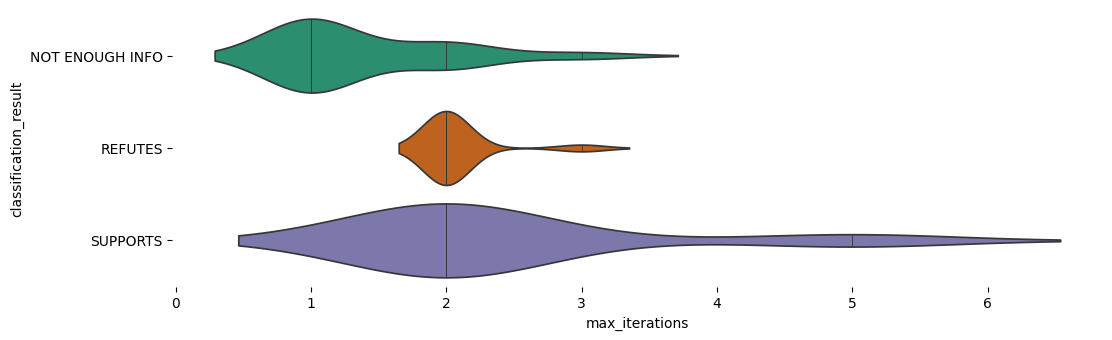

In [ ]:
# @title classification_result vs max_iterations

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(report['classification_result'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(report, x='max_iterations', y='classification_result', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)